<a href="https://colab.research.google.com/github/EricFergs/HRV-Analysis/blob/main/GAF_plot_generating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy import interpolate
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
!pip install pyts
from pyts.image import RecurrencePlot
from pyts.image import GramianAngularField
from tqdm.auto import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 8.3 MB/s eta 0:00:00


In [ ]:
current_directory = Path.cwd()
new_directory = current_directory / 'SV'
new_directory.mkdir(parents=True, exist_ok=True)

In [ ]:
def openchart(filepath):
  file_path = Path(filepath)

  if file_path.is_file():
    with open(filepath, 'rb') as f:
      list = []
      for s in f.readlines():
          try:
              list.append(float(str(s.strip(), 'utf-8')))
          except ValueError:
              print("ValueError occured")
    return list
  return False

In [ ]:
def preprocess(data):
  hrv = pd.DataFrame(data)
  hrv[0] = pd.to_numeric(hrv[0], 'coerce').interpolate()
  hrv['Time'] = pd.to_datetime(hrv[0].cumsum(), unit='ms', errors='coerce')
  hrv = hrv.set_index('Time')


  threshold_min = 350
  threshold_max = 1300
  hrv[(hrv <= threshold_min) | (hrv >= threshold_max)] = np.NaN
  max_difference = 0.2
  n_repetitions = 10
  for i in range(n_repetitions):
      hrv['dRRI'] = (hrv[0].diff().fillna(0)).abs()
      thresholds = hrv.dRRI/hrv[0]
      hrv.iloc[thresholds > max_difference, 0] = np.NaN
      interpolation_method = 'linear'
      hrv = hrv.interpolate(method=interpolation_method).drop(columns='dRRI')


  target_rp_size = 128
  coarse_grained_hrv = hrv.reset_index()
  downsampling_factor = int(np.ceil(len(coarse_grained_hrv) / target_rp_size))
  coarse_grained_hrv = hrv.groupby(coarse_grained_hrv.index // downsampling_factor).mean()
  coarse_grained_hrv.reset_index(inplace=True)
  coarse_grained_hrv.set_index('index', inplace=True)
  hrv = coarse_grained_hrv
  clean_hrv = hrv.to_numpy().flatten()
  hrv_data = clean_hrv.reshape(1, -1)
  return hrv_data


In [ ]:
def process_and_save_gaf(data, endpath, file_prefix, method='s'):
    transformer = GramianAngularField(method=method, image_size=data.shape[1])

    # Transform the entire data into a Gramian Angular Field
    gaf_image = transformer.fit_transform(data.reshape(1, -1))

    # Save the GAF image to the specified directory
    np.save(endpath / f'{file_prefix}_{method}_gaf.npy', gaf_image)


In [ ]:
endpath = new_directory
datapath = Path('dataSV')
def processandsave(datapath, endpath):
    for i, file_path in tqdm(enumerate(datapath.iterdir())):
        list = openchart(file_path)
        if list:
          hrv = preprocess(list)
          process_and_save_gaf(hrv, endpath, str(i))

In [ ]:
processandsave(datapath, endpath)

0it [00:00, ?it/s]

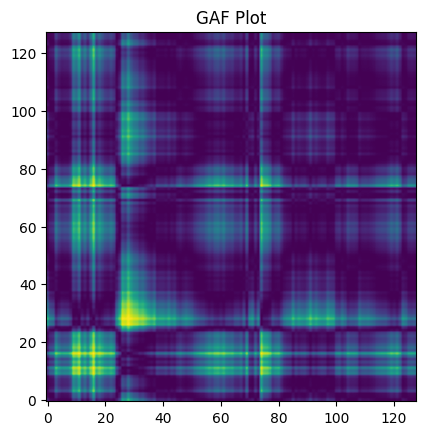

In [ ]:
gaftest = Path('GAF SV charts/10_s_gaf.npy')
gaf_plot = np.load(gaftest)
plt.imshow(gaf_plot[0], cmap='viridis', origin='lower')
plt.title('GAF Plot')
plt.show()

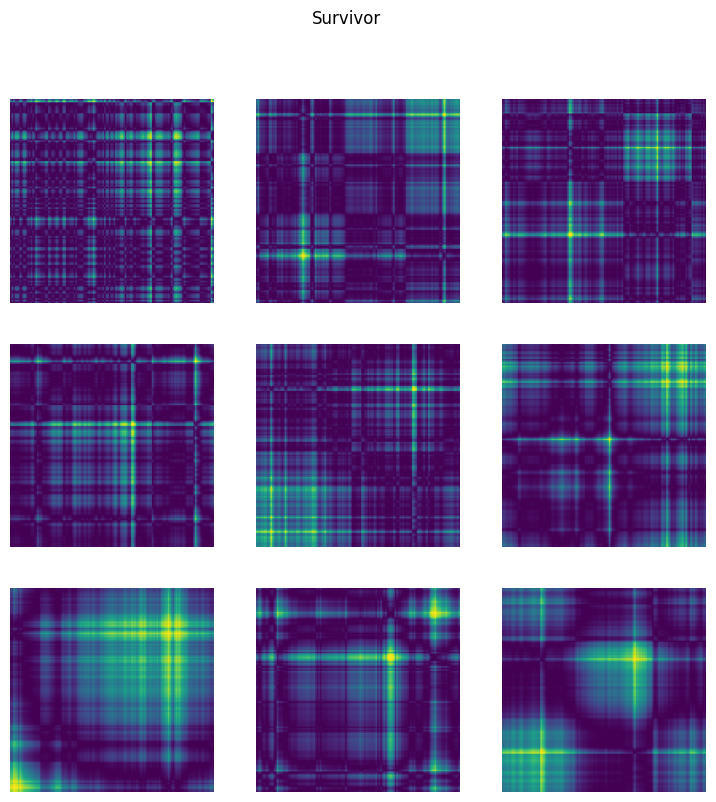

In [ ]:
plt.figure(figsize=(9,9))
plt.suptitle("Survivor")
nrows = 3
ncols = 3
for i in range(0,9):
  plt.subplot(nrows, ncols, i+1)
  gaftest = Path(f'GAF SV charts/{i}_s_gaf.npy')
  gaf_plot = np.load(gaftest)
  plt.imshow(gaf_plot[0], cmap='viridis', origin='lower')
  plt.axis(False)

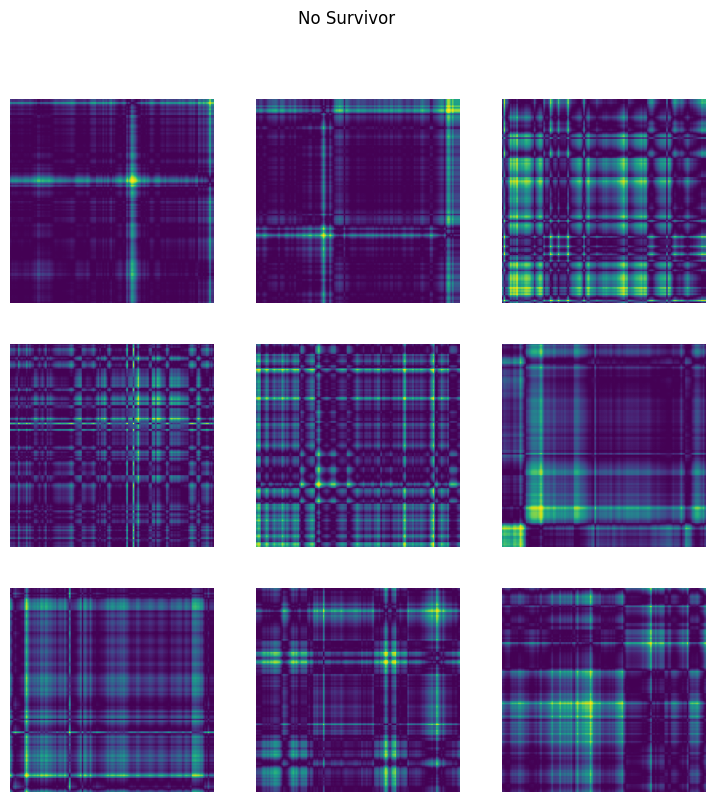

In [ ]:
plt.figure(figsize=(9,9))
plt.suptitle("No Survivor")
nrows = 3
ncols = 3
for i in range(0,9):
  plt.subplot(nrows, ncols, i+1)
  gaftest = Path(f'GAF charts/{i}_s_gaf.npy')
  gaf_plot = np.load(gaftest)
  plt.imshow(gaf_plot[0], cmap='viridis', origin='lower')
  plt.axis(False)

In [ ]:
import shutil
from google.colab import files

In [ ]:
folder_to_zip = '/content/GAF SV charts'  # Path to the folder you want to zip
zip_filename = '/content/GAF_SV_charts.zip'  # Path and name of the zip file

# Compress the folder into a zip file
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', folder_to_zip)

# Download the zip file
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ls

 data/   dataSV/  'GAF charts'/   GAF_charts.zip   sample_data/
